### Students
- Student: <span style="color:green">253885 - Luca Franceschi</span>

# Lab 3: The geometry of two views and 3D reconstruction

In this lab session, we are going to compute the 3D position of a pair of cameras and a set of keypoints.  For this, we will first compute correspondences between the two images.  Then, we will robustly compute the Fundamental matrix that encodes the geometry of the two views. From the Fundamental matrix and the camera calibration matrix -- that we learnt to estimate in the third lab session -- we will get the Essential matrix, which encodes the relative motion between the two cameras.  We will then compute the motion between the cameras and, finally, triangulate the matched keypoints to obtain their 3D position.

The goals of this lab assignment are the following:

- How to estimate the fundamental matrix that relates two images, corresponding to two different views of the same scene, given a set of correspondences between them. In particular, we will use the 8-point algorithm.

- How to compute the relative pose of two calibrated cameras

- How to triangulate point matches to reconstruct their 3D position.

You will have to answer the questions and complete the provided code when necessary as required. **You must deliver the completed (and executed) ipynb file, including the answers to the questions (please make clear visually what it is answer, either preceding it by ANSWER and/or changing its color).**

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Introduction</strong>:
  <ul>
    <li>Provide an overall explanation of the lab. Describe the goals of the lab clearly.</li>
    <li>State the problem you were trying to solve or explore in this lab.</li>
  </ul>
</div>


## **1. Estimation of the fundamental matrix**

### **1.1 The 8-point algorithm**

The first task is to create the function that estimates the fundamental matrix given a set of point correspondences between a pair of images. We provide the incomplete function `fundamental_matrix` that computes,
with the normalised 8-point algorithm, an estimation of the Fundamental matrix
from a set of tentative point correspondences.  



**Q1.** Complete the function `fundamental_matrix` below.


In [1]:
import logging
import math
import random
import sys

import cv2
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Markdown
from matplotlib import pyplot as plt
from utils import plot_camera

from tqdm.notebook import tqdm

In [2]:
def Normalization(x):
    x = np.asarray(x)
    x = x / x[2, :]

    m, s = np.mean(x, 1), np.std(x)
    s = np.sqrt(2) / s

    # TODO: compute the transformation matrix T
    T = np.array([[s, 0, -s*m[0]],
                  [0, s, -s*m[1]],
                  [0, 0, 1]])

    xt = T @ x

    return T, xt


def fundamental_matrix(points1, points2):

    # Normalize points in both images
    T1, points1n = Normalization(points1)
    T2, points2n = Normalization(points2)

    # TODO: compute the fundamental matrix F
    N = points1n.shape[1]

    # Compute A
    A = np.zeros((N, 9))
    for i in range(N):
        x = points1n[:, i]
        y = points2n[:, i]
        A[i, :] = np.array([y[0]*x[0], y[0]*x[1], y[0], y[1]*x[0], y[1]*x[1], y[1], x[0], x[1], 1])
    
    # Solve Af = 0
    _, _, Vh = np.linalg.svd(A) # check it comes transposed
    f = Vh[-1, :]

    # Reshape F from column array to matrix
    F = np.reshape(f, (3, 3))

    # Impose sigma_3 = 0 --> ideal case
    U, D, Vh = np.linalg.svd(F)
    D = np.diag(D)
    D[-1, -1] = 0
    F = U @ D @ Vh

    assert(np.linalg.matrix_rank(F) == 2)

    # Denormalize
    F = T2.T @ F @ T1

    return F

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <ul style="margin: 0; padding-left: 20px;">
    <strong>🎥 Video Question 2:</strong><br>
    <li>Why do we need to enforce the rank 2 constraint?<br>
    <li>How do we enforce it?<br>
  </ul>
</div>

The code below contains a toy example where we know the ground truth correspondences and ground-truth fundamental matrix. Use the code to test that the completed function is working properly.

In [3]:
# Two camera matrices for testing purposes
P1 = np.zeros((3, 4))
P1[0, 0] = P1[1, 1] = P1[2, 2] = 1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[0.3, 0.1, 0.2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0, 1, n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0, 1, 2 * n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1, n))
X = np.concatenate((rand2, 3 * rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate fundamental matrix (you need to create this function)
logging.getLogger().setLevel(logging.DEBUG)  # For debugging purposes :)
F_es = fundamental_matrix(x1_test, x2_test)
logging.getLogger().setLevel(logging.INFO)  # Avoiding overprinting from now on :)


# Ground truth fundamental matrix
A = np.array([[0, -t[0, 2], t[0, 1]], [t[0, 2], 0, -t[0, 0]], [-t[0, 1], t[0, 0], 0]])
F_gt = A @ R

# Evaluation: these two matrices should be very similar
F_gt = np.sign(F_gt[0, 0]) * F_gt / np.linalg.norm(F_gt)
F_es = np.sign(F_es[0, 0]) * F_es / np.linalg.norm(F_es)
dif_norm = np.linalg.norm(F_gt - F_es)
logging.info(
    ("\n" * 2).join([f"\n\nGround truth F: {F_gt}", f"Estimated F: {F_es}", f"Norm of the difference: {dif_norm}"])
)

if dif_norm < 1e-5:
    display(
        Markdown(
            '<span style="color: #00ff00">The function `fundamental_matrix()` seems correct!<br>'
            f"Norm of the difference between estimated and ground truth matrix is {dif_norm:.3g}; i.e. almost zero.</span>"
        )
    )
else:
    display(
        Markdown(
            '<span style="color: #ff0000">The function `fundamental_matrix()` might be wrong!<br>'
            f"Norm of the difference between estimated and ground truth matrix is {dif_norm:.3g}; i.e. different from zero.</span>"
        )
    )

INFO:root:

Ground truth F: [[ 0.0978244   0.36508565 -0.18898224]
 [-0.36508565  0.0978244   0.56694671]
 [ 0.03580622 -0.59654067 -0.        ]]

Estimated F: [[ 9.78244040e-02  3.65085646e-01 -1.88982237e-01]
 [-3.65085646e-01  9.78244040e-02  5.66946710e-01]
 [ 3.58062170e-02 -5.96540671e-01 -2.68487361e-16]]

Norm of the difference: 3.4217288007815915e-14


<span style="color: #00ff00">The function `fundamental_matrix()` seems correct!<br>Norm of the difference between estimated and ground truth matrix is 3.42e-14; i.e. almost zero.</span>

### **1.2 Robust estimation of the fundamental matrix**

The next step is to robustly compute the Fundamental matrix from the point correspondences. For that we will use the function `ransac_fundamental_matrix` that you have to complete.

The next code computes the image correspondences.

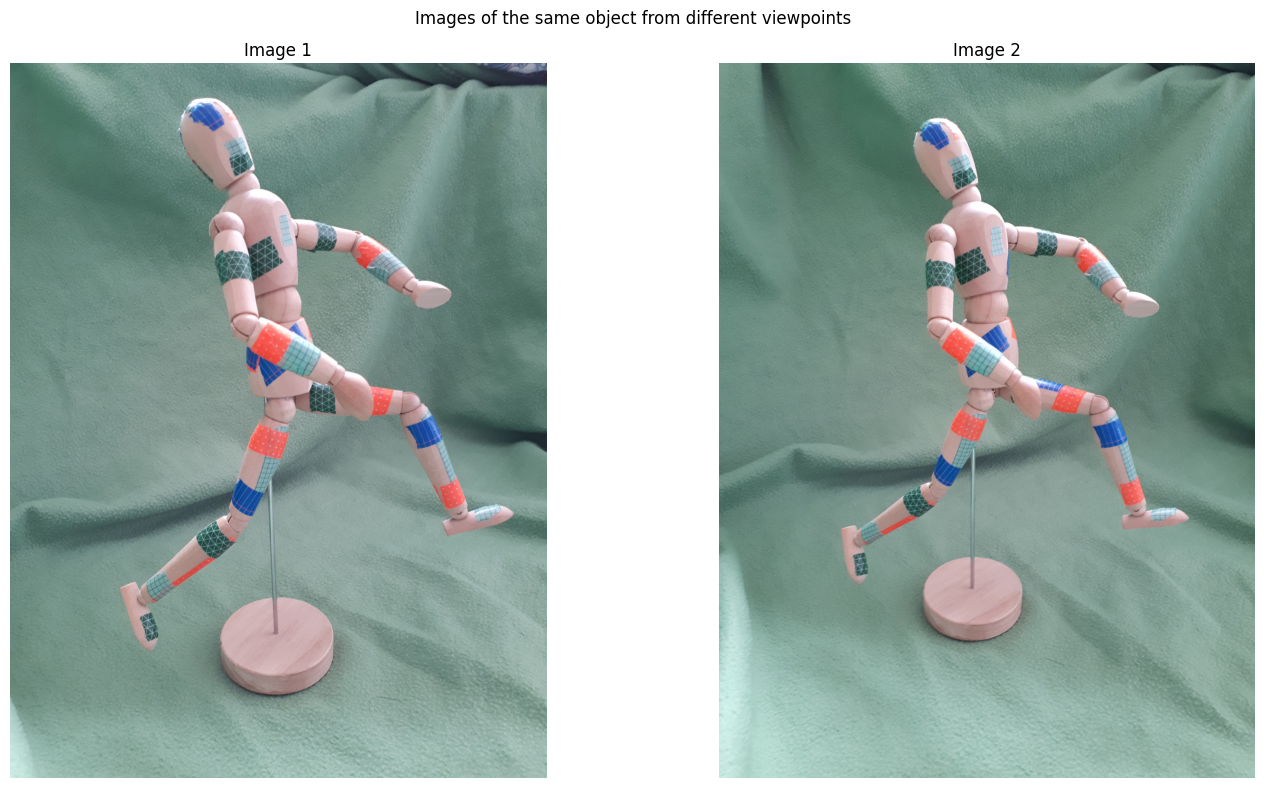

In [4]:
# Read images
img1_bgr = cv2.imread("Data/manikin1.jpg", cv2.IMREAD_COLOR)
img2_bgr = cv2.imread("Data/manikin2.jpg", cv2.IMREAD_COLOR)
img1_rgb = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 8))
plt.suptitle("Images of the same object from different viewpoints")
for i, image in enumerate([img1_rgb, img2_rgb], start=1):
    plt.subplot(1, 2, i)
    plt.title(f"Image {i}")
    plt.imshow(image)
    plt.axis("off")
plt.tight_layout()
plt.show()

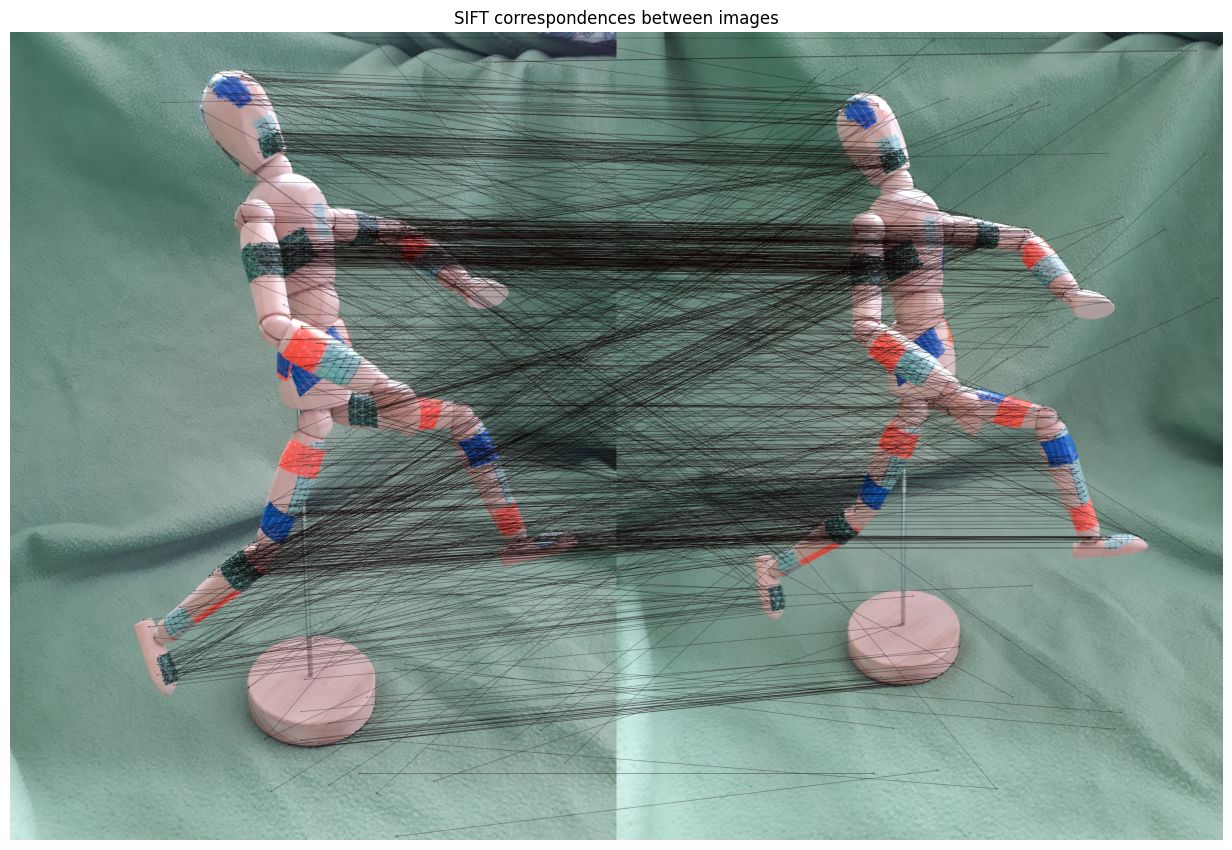

In [5]:
# Read images
img1_gray = cv2.imread("Data/manikin1.jpg", cv2.IMREAD_GRAYSCALE)
img2_gray = cv2.imread("Data/manikin2.jpg", cv2.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv2.SIFT_create(3000)

# find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Show matches
img_12 = cv2.drawMatches(
    img1_rgb, kp1, img2_rgb, kp2, matches, None, 12, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(18.5, 10.5))
plt.title("SIFT correspondences between images")
plt.imshow(img_12)
plt.axis("off")
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q3):</strong>
  <ul>
    <li>The function compute_inliers() is provided. How does it select the inliers?</li>
  </ul>
</div>


**Q4.** Complete the function `ransac_fundamental_matrix` below.

In [ ]:
def compute_inliers(F, x1, x2, th):

    # Project the points into epipolar lines
    Fx1 = F @ x1
    Ftx2 = F.T @ x2

    n = x1.shape[1]
    x2tFx1 = np.zeros((1, n))

    # For each point, calculate epipolar constraint
    for i in range(n):
        x2tFx1[0, i] = x2[:, i].T @ F @ x1[:, i]

    # Evaluate distances (how close is a point to its epipolar line)
    den = Fx1[0, :] ** 2 + Fx1[1, :] ** 2 + Ftx2[0, :] ** 2 + Ftx2[1, :] ** 2
    den = den.reshape((1, n))

    d = x2tFx1**2 / den

    # If the distance to epipolar lines are relatively small (<th) then is inlier
    inliers_indices = np.where(d[0, :] < th)

    return inliers_indices[0]


def ransac_fundamental_matrix(points1, points2, th, min_iterations):

    Ncoords, Npts = points1.shape

    p = 0.99
    # TODO: Select the number of correspondences to sample
    s = 8

    it = 0
    N = min_iterations
    best_inliers = np.empty(1)
    best_N = 1e16

    # Initialize tqdm with dynamic total
    pbar = tqdm(total=N, desc="RANSAC iterations", unit="iter")
    
    while it < N:

        # TODO: Randomly select s correspondences to compute F and its inliers
        indices = random.sample(range(Npts), s)
        F = fundamental_matrix(points1[:, indices], points2[:, indices])
        inliers = compute_inliers(F, points1, points2, th)

        # update estimate of iterations (the number of trials) to ensure we pick, with probability p,
        # an initial data set with no outliers
        w = inliers.shape[0] / Npts
        pOutlier = 1 - w**s
        eps = sys.float_info.epsilon
        pOutlier = max(eps, pOutlier)  # avoid log(0) that would cause a division by -Inf
        pOutlier = min(1 - eps, pOutlier)  # avoid log(1) that would cause a division by 0
        estimated_N = math.log(1 - p) / math.log(pOutlier)
        best_N = min(best_N, estimated_N)  # Keep the best (lowest) N
        N = max(min_iterations, best_N)  # Ensure at least min_iterations

        # TODO: Update the best inliers

        if len(inliers) >= len(best_inliers):
            print(f"it:{it} - best inliers: {len(best_inliers)} - w: {w:.2f} - N: {N:.5g}")
            best_inliers = inliers

        if int(N) > pbar.total:
            pbar.total = int(N)
            pbar.refresh()

        pbar.update(1)
        it += 1

    pbar.close()

    print(f"Number of iterations: {it}, best inliers: {len(best_inliers)} - N: {N:.5g}")

    # Recompute F from all the inliers
    F = fundamental_matrix(points1[:, best_inliers], points2[:, best_inliers])
    inliers_recomputed = compute_inliers(F, points1, points2, th)
    print(f"Recomputed inliers: {len(inliers_recomputed)}")

    return F, best_inliers

In [7]:
# Robust estimation of the fundamental matrix
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])

points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = ransac_fundamental_matrix(points1, points2, th=2, min_iterations=5000)
inlier_matches = [matches[i] for i in indices_inlier_matches]

RANSAC iterations:   0%|          | 0/5000 [00:00<?, ?iter/s]

it:0 - best inliers: 1 - w: 0.01 - N: 1e+16
it:1 - best inliers: 10 - w: 0.01 - N: 1e+16
it:3 - best inliers: 12 - w: 0.03 - N: 5.1432e+12
it:12 - best inliers: 32 - w: 0.04 - N: 7.0819e+11
it:21 - best inliers: 41 - w: 0.04 - N: 2.8207e+11
it:51 - best inliers: 46 - w: 0.05 - N: 6.7534e+10
it:77 - best inliers: 55 - w: 0.31 - N: 55454
it:15676 - best inliers: 317 - w: 0.34 - N: 25110
Number of iterations: 25110, best inliers: 350 - N: 25110
Recomputed inliers: 378


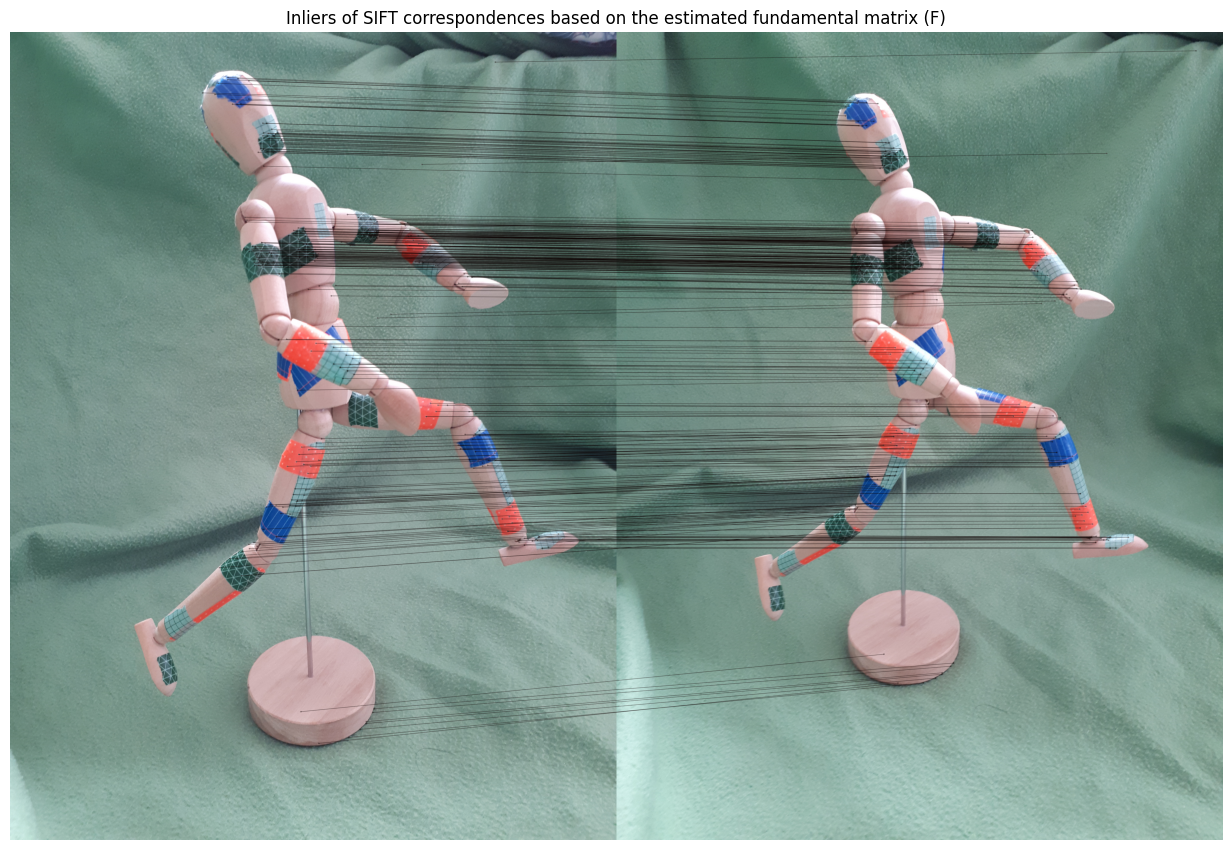

In [8]:
img_12 = cv2.drawMatches(
    img1_rgb, kp1, img2_rgb, kp2, inlier_matches, None, 12, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(18.5, 10.5))
plt.title("Inliers of SIFT correspondences based on the estimated fundamental matrix (F)")
plt.imshow(img_12)
plt.axis("off")
plt.show()

### **1.3 Epipolar lines**

We will now visualize the epipolar lines associated to some points.

**Q5.** Choose 3 inlier points in the first image and compute their corresponding epipolar lines (in homogeneous coordinates) in the second image. Do the same but now choosing points in the second image and showing their epipolar lines in the first image. Provide the commands you used for that. The commands for showing the lines on top of the image are already provided.

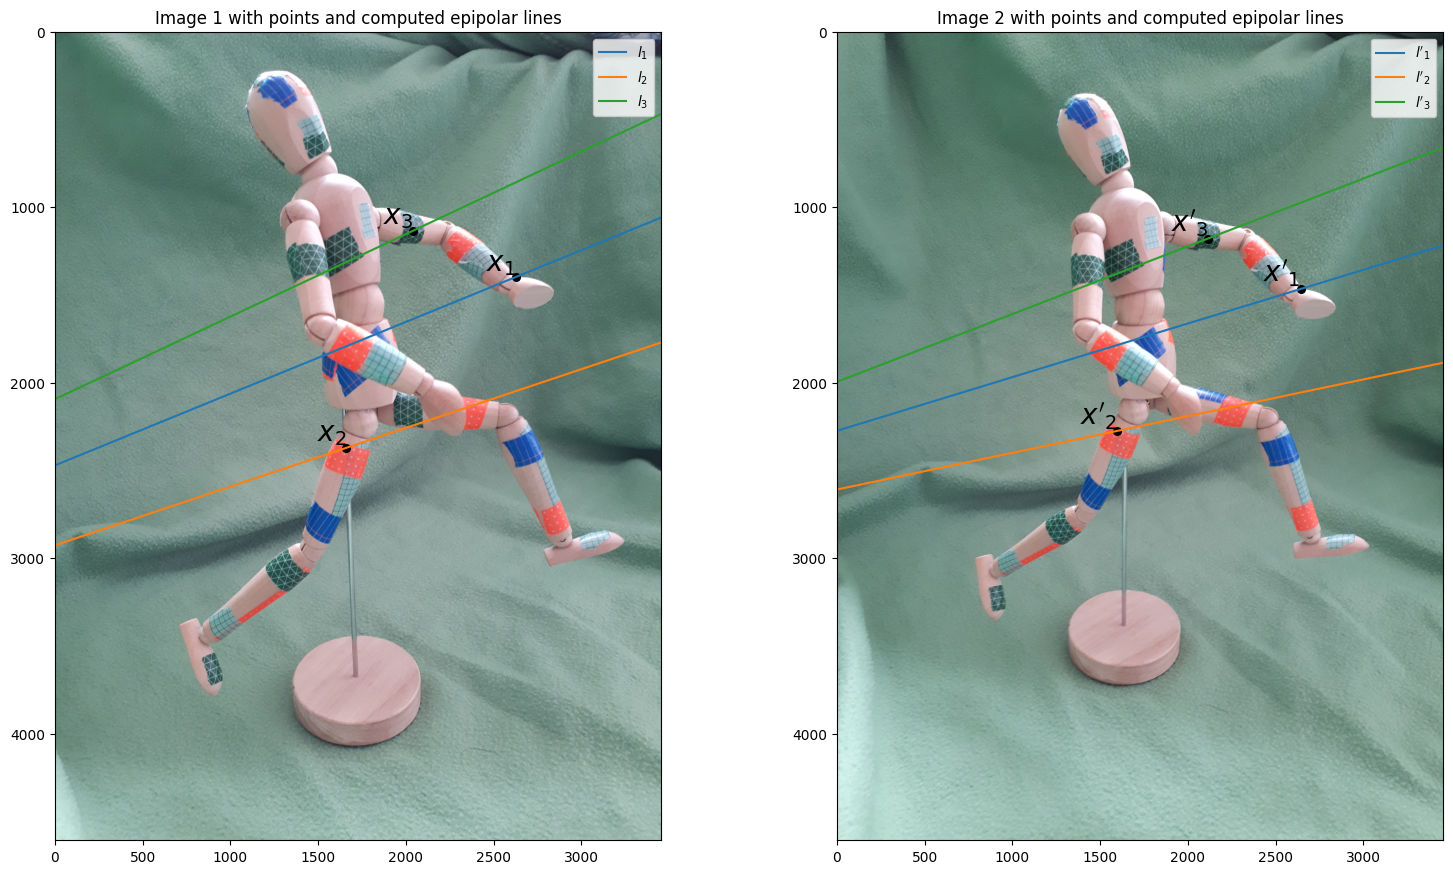

In [9]:
# TODO: compute the epipolar lines
l2 = F @ points1
l1 = F.T @ points2

# choose three random indices
N = indices_inlier_matches.shape[0]
indices = random.sample(range(1, N), 3)

selected_indices = indices_inlier_matches[indices]

# Function required to display lines
def get_line_points(l, I):
    x = np.arange(0, np.array(I).shape[1])
    y = (-l[0] * x - l[2]) / l[1]
    return x, y


# Display image with epipolar lines and points
plt.figure(figsize=(18.5, 10.5))
points_color = "black"
for num_plot, (image, epipolar_lines, points) in enumerate(
    zip([img1_rgb, img2_rgb], [l1, l2], [points1, points2]), start=1
):
    plt.subplot(1, 2, num_plot)
    plt.title(f"Image {num_plot} with points and computed epipolar lines")
    for i, index in enumerate(selected_indices, start=1):
        plt.plot(*get_line_points(epipolar_lines[:, index], image), label=f"$l{chr(39) * (num_plot == 2)}_{i}$")

    for i, (x, y) in enumerate(zip(points[0, selected_indices], points[1, selected_indices]), start=1):
        plt.scatter(x=x, y=y, c=points_color, s=30)
        plt.text(
            x,
            y,
            f"$x{chr(39) * (num_plot == 2)}_{i}$",
            fontsize=20,
            ha="right",
            va="bottom",
            color=points_color,
            weight="bold",
        )
    plt.imshow(image)
    plt.legend()
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q5b):</strong>
  <ul>
    <li>How did you obtain the epipolar lines?</li>
    <li>Where do they intersect?</li>
  </ul>
</div>

**Q6.** First, compute the epipoles from the Fundamental matrix. Then, compute the epipolar lines as the line that passes through the matching point and the epipole. Check that you obtain the same epipolar lines as before.

In [10]:
## SOLUTION yikes
# # Epipole of the first image
U, d, Vt = np.linalg.svd(F)
epipole1 = Vt[-1, :]
print(f"Epipole first image (from fundamental matrix): {epipole1}")
epipole1_intersetion = np.cross(l1[:, 10], l1[:, 121])
epipole1_intersetion /= np.linalg.norm(epipole1_intersetion)
print(f"Epipole first image (from intersection of epipolar lines): {epipole1_intersetion}")

line_1 = l1[:, 2]
print(f"Epipolar line 1: {line_1 / line_1[-1]}")
line1_intersection = np.cross(epipole1, points1[:, 2])
print(f"Epipolar line 1: {line1_intersection / line1_intersection[-1]}")

print("\n\n")

# Epipole of the second image
U, d, Vt = np.linalg.svd(F.T)
epipole2 = Vt[-1, :]
print(f"Epipole second image (from fundamental matrix): {epipole2}")
epipole2_intersetion = np.cross(l2[:, 10], l2[:, 121])
epipole2_intersetion /= np.linalg.norm(epipole2_intersetion)
print(f"Epipole second image (from intersection of epipolar lines): {epipole2_intersetion}")

line_2 = l2[:, 456]
print(f"Epipolar line 2: {line_2 / line_2[-1]}")
line2_intersection = np.cross(epipole2, points2[:, 456])
print(f"Epipolar line 2: {line2_intersection / line2_intersection[-1]}")

Epipole first image (from fundamental matrix): [-7.76397195e-01  6.30243905e-01  1.26616690e-04]
Epipole first image (from intersection of epipolar lines): [-7.76397195e-01  6.30243905e-01  1.26616690e-04]
Epipolar line 1: [-2.15772002e-04 -4.66710530e-04  1.00000000e+00]
Epipolar line 1: [-2.15803894e-04 -4.66749817e-04  1.00000000e+00]



Epipole second image (from fundamental matrix): [-7.20637857e-01  6.93311644e-01  2.08036849e-04]
Epipole second image (from intersection of epipolar lines): [-7.20637857e-01  6.93311644e-01  2.08036849e-04]
Epipolar line 2: [-8.52370053e-05 -3.88659075e-04  1.00000000e+00]
Epipolar line 2: [-1.83686622e-04 -4.90988989e-04  1.00000000e+00]


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q6b):</strong>
  <ul>
    <li>Explain the previous cell. Why does it work?</li>
  </ul>
</div>

**ANSWER**

We know that the epipole in the first image $\textbf{e} \in {\mathbb{P}}^3$ can be retrieved as the right null vector of F (i.e.: $F\textbf{e} = 0$). Similarly, the epipole in the second image $\textbf{e}^\prime \in {\mathbb{P}}^3$ can be retrieved as the left null vector of F (i.e.: $F^\top\textbf{e}^\prime = 0$).

As many times before, the solution to this kind of linear system lies in the Singular Value Decomposition of F, as the last row of the Vt matrirx. The epipole in the second image could also be extracted from the last column of the U matrix, instead of having to compute the SVD of F transpose.

## 2. Structure computation

### **2.1 Triangulation**

Before recovering the camera motion, we will first need to implement a function to triangulate matches.  This is a function that takes as input a match and the projection matrices of two cameras, and computes the 3D position of a match.

We want then to find the 3D point $\mathbf{X}$ such that its projection onto the images are $\mathbf{x} = P \mathbf{X}$ and $\mathbf{x'} = P' \mathbf{X}$ (being $P$ and $P'$ the projection matrices of each camera).


**Q7.** Derive the expression of matrix $A$ in the system of equations in algebraic form, $A \mathbf{X} = \mathbf{0}$, that we need to solve in order to estimate the homogeneous coordinates of the 3D point $\mathbf{X}$.

**ANSWER**

I will do the proof for the first image projections of the point $\textbf{x}$, however it is the exact same thing with $\textbf{x}^\prime$. Starting from the fact that

$$
\textbf{x} \equiv P \textbf{X}
$$

which means that they are equal up to a scaling factor. In the form of an equality, we can say that

$$
\lambda\textbf{x} = P \textbf{X}
$$

$$
\lambda \begin{pmatrix}
x \\
y \\
1
\end{pmatrix}
=
\begin{pmatrix}
\textbf{p}_1^\top \\
\textbf{p}_2^\top \\
\textbf{p}_3^\top
\end{pmatrix}
\textbf{X}
=
\begin{pmatrix}
\textbf{p}_1^\top \textbf{X} \\
\textbf{p}_2^\top \textbf{X} \\
\textbf{p}_3^\top \textbf{X}
\end{pmatrix}
$$

which can be rewritten into the following linear system of equations

$$
\left\{
\begin{aligned}
\lambda x &= \textbf{p}_1^\top \textbf{X} \\
\lambda y &= \textbf{p}_2^\top \textbf{X} \\
\lambda   &= \textbf{p}_3^\top \textbf{X}
\end{aligned}
\right.
$$

finally if we substitute the expression for lambda in the first two equations we end up with the following two linearly independent equations

$$
\left\{
\begin{aligned}
\textbf{p}_3^\top \textbf{X} x - \textbf{p}_1^\top \textbf{X} = 0 \\
\textbf{p}_3^\top \textbf{X} y - \textbf{p}_2^\top \textbf{X} = 0 \\
\end{aligned}
\right.
$$

These equations for $\textbf{x}$ in the form of $A\textbf{X} = \textbf{0}$ gives us the following expression for $A$

$$
A_\textbf{x} = 
\begin{pmatrix}
\textbf{p}_3^\top x - \textbf{p}_1^\top \\
\textbf{p}_3^\top y - \textbf{p}_2^\top \\
\end{pmatrix}
$$

When we stack also the two equations for $\textbf{x}^\prime$ we get our final expression for $A$

$$
A = 
\begin{pmatrix}
\textbf{p}_3^\top x - \textbf{p}_1^\top \\
\textbf{p}_3^\top y - \textbf{p}_2^\top \\
\textbf{p}_3'^\top x' - \textbf{p}_1'^\top \\
\textbf{p}_3'^\top y' - \textbf{p}_2'^\top \\
\end{pmatrix}
$$

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q7b):</strong>
  <ul>
    <li>Explain the theoretical solution above</li>
  </ul>
</div>


**Q8.** Complete the code of the `triangulate`function below.

In [11]:
def triangulate(x1, x2, P1, P2, imsize):

    # only one point
    if x1.ndim == 1:
        x1 = np.array([x1]).T
        x2 = np.array([x2]).T

    # number of points
    n = x1.shape[1]

    # Normalization
    x1 = x1 / x1[2, :]
    x2 = x2 / x2[2, :]

    nx = imsize[0]
    ny = imsize[1]

    H = [[2 / nx, 0, -1], [0, 2 / ny, -1], [0, 0, 1]]

    x1_norm = H @ x1
    x2_norm = H @ x2
    P1_norm = H @ P1
    P2_norm = H @ P2

    # TODO: compute the triangulated points
    A = np.empty((4, 4))
    X = np.empty((4, n))
    for i in range(n): # no fancy way without for loop ?
        A[0, :] = np.array([x1_norm[0, i]*P1_norm[2, :] - P1_norm[0, :]])
        A[1, :] = np.array([x1_norm[1, i]*P1_norm[2, :] - P1_norm[1, :]])
        A[2, :] = np.array([x2_norm[0, i]*P2_norm[2, :] - P2_norm[0, :]])
        A[3, :] = np.array([x2_norm[1, i]*P2_norm[2, :] - P2_norm[1, :]])

        _, _, Vt = np.linalg.svd(A)

        # NOTE: no need to unnormalize
        X[:, i] = Vt[-1, :]

    return X

You may use the following test code with a toy example to validate that the `triangulate`function is working properly.
In summary, this code simulates the process of 3D point projection, triangulation, and evaluation of the reprojection error in a scenario with two cameras and randomly generated 3D points.

In [12]:
# Define Camera Matrices
# P1 is initialized as the identity matrix (3x4)
P1 = np.eye(3, 4)

# P2 is generated by applying a rotation of 15 degrees around the z-axis and a translation
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[0.3, 0.1, 0.2]])
P2 = np.concatenate((R, t.T), axis=1)

# Generate n random 3D Points
# Each point is represented as a homogeneous 4D vector
n = 8
rand = np.random.uniform(0, 1, n).reshape((1, n))
rand2 = np.random.uniform(0, 1, 2 * n).reshape((2, n))
ones = np.ones((1, n))
X = np.concatenate((rand2, 3 * rand, ones), axis=0)

# Project 3D Points
# 3D points are projected onto the image planes of the two cameras
x1_test = P1 @ X
x2_test = P2 @ X

# Estimate the 3D points (you need to create this function)
# The function triangulate() is called to estimate the 3D coordinates of the points using the corresponding 2D points and camera matrices
x_trian = triangulate(x1_test, x2_test, P1, P2, ((2, 2)))

# Evaluation: compute the reprojection error
# The synthetic 3D points (X_eucl) and the triangulated 3D points (x_eucl) are converted from homogeneous coordinates to Euclidean coordinates.
x_eucl = x_trian / x_trian[3, :]
X_eucl = X / X[3, :]
# The difference between these two sets of points is computed and printed as the reprojection error.
reproj_err = np.linalg.norm(X_eucl - x_eucl, axis=0)
print(f"Reprojection error for n={n} points:", reproj_err, sep="\n", end="\n" * 2)
if np.allclose(reproj_err, 0, atol=1e-5):
    display(Markdown('<span style="color: #00ff00">The function `triangulate()` seems correct!</span>'))
else:
    display(Markdown('<span style="color: #ff0000">The function `triangulate()` might be wrong!</span>'))

Reprojection error for n=8 points:
[2.27798719e-15 3.29719416e-15 3.59753377e-16 4.97971402e-16
 1.22628141e-15 1.62031716e-15 2.14204003e-15 5.97873396e-16]



<span style="color: #00ff00">The function `triangulate()` seems correct!</span>

### 2.2 Relative motion between the two cameras
As seen in the theory class, the relative position between the cameras can be computed from the Essential matrix, $E$. In order to estimate $E$, we need the Fundamental matrix, $F$, that we have just computed and the camera calibration matrix, $K$, that we learnt how to estimate during the second lab.

**Q9.** Compute the Essential matrix from the Fundamental matrix and the camera calibration matrix in the code below.

In [13]:
# K matrix estimated as in lab 2
K = np.array([[3531.97, 9.59, 2304.33], [0, 3537.34, 1751.75], [0, 0, 1]])

# TODO: Complete the essential matrix
E = K.T @ F @ K


We will assume that the first camera is at the origin, with no rotation, and that the second camera has a rotation and translation with respect to the first one.

**Q10.** Write the camera projection matrix $P$ for the first camera.

In [14]:
# TODO: Compute the projection matrix of the first camera
P1 = K @ np.eye(3, 4)

print(P1)

[[3.53197e+03 9.59000e+00 2.30433e+03 0.00000e+00]
 [0.00000e+00 3.53734e+03 1.75175e+03 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]


The rotation and translation of the second camera can be computed from the SVD decomposition of $E$. There are four possible solutions.

**Q11.** Complete the code below to compute the four candidate solutions for the second camera projection matrix.

In [15]:
U, D, Vt = np.linalg.svd(E)

# The SVD of E has several ambiguities. In particular, U and V may be
# improper rotations in which case we need to change their sign.
if np.linalg.det(U) < 0:
    U = -U

if np.linalg.det(Vt) < 0:
    Vt = -Vt

W = np.array([[0, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])

# TODO: Find the four potential camera projection matrices for the second camera
Pc2 = np.empty(shape=(4, 3, 4))
Pc2[0] = K @ np.concatenate((U @ W @ Vt, U[:, -1].reshape(3, 1)), axis=1)
Pc2[1] = K @ np.concatenate((U @ W @ Vt, -U[:, -1].reshape(3, 1)), axis=1)
Pc2[2] = K @ np.concatenate((U @ W.T @ Vt, U[:, -1].reshape(3, 1)), axis=1)
Pc2[3] = K @ np.concatenate((U @ W.T @ Vt, -U[:, -1].reshape(3, 1)), axis=1)

ny, nx, _ = img1_rgb.shape

fig = go.Figure()
plot_camera(P1, nx, ny, fig, "Reference camera")
for i in range(4):
    plot_camera(Pc2[i], nx, ny, fig, f"Camera_2-Option_{i+1}")
fig.show()

### Selecting the proper camera projection matrix

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q12):</strong>
  <ul>
    <li>How can we choose the right solution from the four candidates? The code to do it is provided below, explain how it works.</li>
  </ul>
</div>

In [ ]:
x1 = points1[:, indices_inlier_matches]
x2 = points2[:, indices_inlier_matches]

# We iterate over all 3 possible cameras (fixing the first one with R = I, t = 0)
for P2i in Pc2:

    Xi = triangulate(x1[:, 0], x2[:, 0], P1, P2i, [nx, ny])
    Xi = Xi / Xi[3, :]

    x1est = P1 @ Xi
    x2est = P2i @ Xi

    # If the triangulated points are in front of both cameras
    if (x1est[2] > 0) and (x2est[2] > 0):
        P2 = P2i
        break

fig = go.Figure()
plot_camera(P1, nx, ny, fig, "Camera 1")
plot_camera(P2, nx, ny, fig, "Camera 2")
fig.show()

### **2.3 Reconstruction from two views**

Once the proper solution for the relative motion between cameras is chosen, we can triangulate all the matches to get a sparse point cloud. 

**Q13.** Complete the code to triangulate all matches.

Use the provided code to plot the reconstructed points. If everything went fine, you should recognize the sparse points corresponding to the different parts of the manikin body at their corresponding 3D positions.

In [17]:
# TODO: Triangulate all matches
X = triangulate(x1, x2, P1, P2, img1_rgb.shape)

# Render the 3D point cloud
fig = go.Figure()
plot_camera(P1, nx, ny, fig, "Camera 1")
plot_camera(P2, nx, ny, fig, "Camera 2")
x_img = x1[:2].T.astype(int)
rgb_vals = img1_rgb[x_img[:, 1], x_img[:, 0]]
# rgb_vals = [f"rgb{tuple(x)}" for x in rgb_vals]
rgb_vals = [f"rgb({int(r)},{int(g)},{int(b)})" for r, g, b in rgb_vals]


point_color = [(255, 0, 0), (0, 255, 0)]
fig.add_trace(go.Scatter3d(x=X[0, :], y=X[2, :], z=-X[1, :], mode="markers", marker=dict(size=2, color=rgb_vals)))
fig.show()

Finally, we are going to compute the reprojection error of the reconstructed points.  This is the distance between the detected keypoints, `x1` and `x2`, and the projection of the reconstructed points.

**Q14.** Complete the code to compute the reprojection error of each match. Plot the histogram of the errors with the provided code. Explain the result.

In [18]:
def reprojection_errors(x1, x2, P1, P2, X):
    
    # NOTE: practically extracted from above
    X1 = P1 @ X
    X1_eucl = X1 / X1[2, :]
    X2 = P2 @ X
    X2_eucl = X2 / X2[2, :]
    
    x1_eucl = x1 / x1[2, :]
    x2_eucl = x2 / x2[2, :]

    err1 = np.linalg.norm(X1_eucl - x1_eucl, axis=0)
    err2 = np.linalg.norm(X2_eucl - x2_eucl, axis=0)

    return (err1 + err2) / 2

err = reprojection_errors(x1, x2, P1, P2, X)

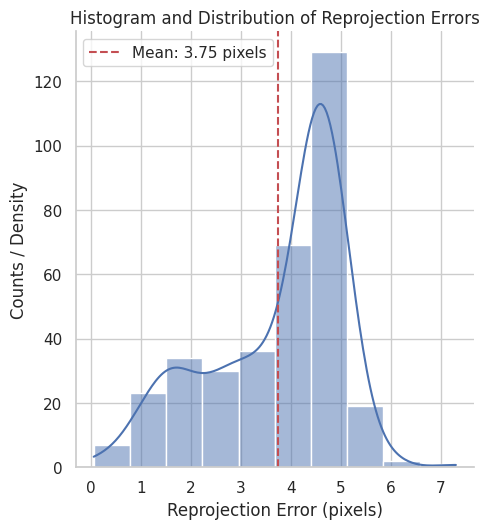

In [19]:
sns.set_theme(style="whitegrid")
ax = sns.displot(err, kde=True, bins=10)
mean_err = np.mean(err)
plt.axvline(x=mean_err, color='r', linestyle='--', label=f'Mean: {mean_err:.2f} pixels')
plt.title("Histogram and Distribution of Reprojection Errors")
plt.xlabel("Reprojection Error (pixels)")
plt.ylabel("Counts / Density")
plt.legend()
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Question (Q14):</strong>
  <ul>
    <li>Interpret the results of the reprojection error above.</li>
  </ul>
</div>

## 3. References

Add here the material you used to complete this Lab. Cite and describe the usage of AI tools if any was used according to the Guidelines for AI tools.

No relevant references apart from lecture / seminar slides.

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(0, 0, 0, 0);">
  <strong>🎥 Video Questions</strong>: Briefly mention the references.
</div>


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color:rgba(0, 0, 0, 0);">
  <strong>🎥 Self-Assessment and Conclusions</strong>:
  <ul>
  <li><b>Which parts of the notebook did you succeed in? </b><br>
  <em>Describe the sections where you felt confident, and explain why you think they were successful.</em></li>
  <li><b>Which parts of the notebook did you fail to solve? </b><br>
  <em>Be honest about the areas where you faced difficulties. What challenges or issues did you encounter that you couldn’t resolve? How would you approach these issues in the future?</em></li>
  </ul>
  Is there anything else that you would like to comment?
</div>
